# <h1 align="center">**Project 2 - Image Processing** </h1>

<h3 align="center"> Nguyễn Thái Đan Sâm - 21127414</h3>

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [50]:
def remake_image(img):
  return np.array(img)

In [51]:
def adjust_brightness(img, brightness):
    adjusted_img = img+np.array([brightness],dtype=np.int16)
    adjusted_img = np.uint8(np.clip(adjusted_img, 0, 255))
    return adjusted_img

def adjust_contrast(img, contrast):
    contrast = np.clip(float(contrast), -255, 255)
    factor = (259 * (contrast + 255)) / (255 * (259 - contrast))
    adjusted_img = factor * (img.astype(float) - 128) + 128
    adjusted_img = np.clip(adjusted_img, 0, 255)
    adjusted_img = adjusted_img.astype(np.uint8)
    return adjusted_img

In [52]:
def flip_vertically(img):
    print (img[::-1])
    return img[::-1]

def flip_horizontally(img):
    print (img[:,::-1])
    return img[:,::-1]


In [53]:
def convert_grayscale(img):
    grayscale_filter = np.array([.299, .587, .114])
    avg = np.dot(img[..., :3],grayscale_filter)
    adjusted_img = np.zeros_like(img)
    for i in range(3):
        adjusted_img[:,:,i] = avg
    adjusted_img = np.clip(adjusted_img,0,255)
    return adjusted_img

def convert_sepia(img):
    sepia_filter = np.array([[.393, .769, .189],
                             [.349, .686, .168],
                             [.272, .534, .131]])
    adjusted_img = np.dot(img[..., :3],sepia_filter.T)
    adjusted_img = np.clip(adjusted_img,0,255)
    return adjusted_img

In [54]:
def blur_image(img):
    sigma = 9 #can be changed (3,5,7,9,...), the bigger the sigma is, the blurrier the image is

    #create kernel (1D array)
    size = int(sigma * 6 + 1)
    x = np.arange(size) - size // 2
    kernel = (1 / (np.sqrt(2 * np.pi) * sigma) * (np.exp(-np.power(x / sigma, 2) / 2)))
    kernel /= np.sum(kernel)

    #apply kernel to each column and row of the image array 
    adjusted_img = np.apply_along_axis(lambda row: np.convolve(row, kernel, mode='same'), axis=1, arr=img)
    adjusted_img = np.apply_along_axis(lambda col: np.convolve(col, kernel, mode='same'), axis=0, arr=adjusted_img)

    return adjusted_img

def sharpen_image(img):
    sigma = 3 #can be changed (3,5,7,9,...), the bigger the sigma is, the blurrier the image is

    #create kernel (1D array)
    size = int(sigma * 6 + 1)
    x = np.arange(size) - size // 2
    kernel = (1 / (np.sqrt(2 * np.pi) * sigma) * (np.exp(-np.power(x / sigma, 2) / 2)))
    kernel /= np.sum(kernel)

    #apply kernel to each column and row of the image array 
    adjusted_B_img = np.apply_along_axis(lambda row: np.convolve(row, kernel, mode='same'), axis=1, arr=img)
    adjusted_B_img = np.apply_along_axis(lambda col: np.convolve(col, kernel, mode='same'), axis=0, arr=adjusted_B_img)

    # Compute the difference between the original image & the blurred image
    diff = img - adjusted_B_img
    # Define the amount of sharpening
    amount = 3 #can be changed (3,5,7,9,...), the bigger the amount is, the sharper the image is
    # Create a new "0" array whose size is equal to the original image one to apply the "sharpen" filter
    adjusted_S_img = np.zeros_like(img)
    # Clip the pixel values to ensure they are within the valid range
    adjusted_S_img = np.clip(img + amount * diff, 0, 255)

    return adjusted_S_img

In [55]:
def crop_center(img, Height, Width):

    height, width = img.shape[:2]
    # Check if the crop size is bigger than the image's size
    if(Height >= int(height)):
        return img
    if(Width >= int(width)):
        return img
    else:
        left = (width - Width) // 2
        up = (height - Height) // 2
        right = (width + Width) // 2
        down = (height + Height) // 2

        cropped_img = img[up:down, left:right]

        return cropped_img
    

In [56]:
def crop_circle(img):
    height, width = img.shape[:2]

    diameter = min(width, height)

    radius = diameter // 2
    center_x = width // 2
    center_y = height // 2

    cropped_img = np.zeros_like(img)

    for y in range(height):
        for x in range(width):
            distance_squared = (x - center_x)**2 + (y - center_y)**2
            if distance_squared <= radius**2:
                cropped_img[y, x] = img[y, x]

    return cropped_img


In [57]:
def ellipse_mask(width, height, center_x, center_y, ellipse_width, ellipse_height, angle):
    y, x = np.ogrid[:height, :width]

    x_rot = (x - center_x) * np.cos(np.radians(angle)) - (y - center_y) * np.sin(np.radians(angle)) 
    y_rot = (x - center_x) * np.sin(np.radians(angle)) + (y - center_y) * np.cos(np.radians(angle)) 

    mask = ((x_rot) ** 2) / (ellipse_width ** 2) + ((y_rot) ** 2) / (ellipse_height ** 2) <= 1

    return mask

def crop_ellipse(img):
    height, width = img.shape[:2]

    diameter = min(height,width)

    x_0 = diameter // 2 
    y_0 = diameter // 2
    
    angle=45
    
    k=(-x_0*np.cos(np.radians(angle))+y_0*np.sin(np.radians(angle))//2)**2
    l=(-x_0*np.sin(np.radians(angle))-y_0*np.cos(np.radians(angle))//2)**2
    m=(-x_0*np.cos(np.radians(angle))//2+y_0*np.sin(np.radians(angle)))**2
    n=(-x_0*np.sin(np.radians(angle))//2-y_0*np.cos(np.radians(angle)))**2
    
    A=np.array([[k,l],
               [m,n]])
    B=np.array([1,1])
    X=np.linalg.solve(A,B)

    ellipse_height = np.sqrt(1/X[0])
    ellipse_width = np.sqrt(1/X[1])
    
    ellipse1_mask = ellipse_mask(width, height, x_0, y_0, ellipse_width, ellipse_height, angle)
    ellipse2_mask = ellipse_mask(width, height, x_0, x_0, ellipse_height, ellipse_width, angle)
    mask = np.logical_or(ellipse1_mask, ellipse2_mask)
    
    cropped_img = np.zeros_like(img)
    cropped_img[mask] = img[mask]
    
    return cropped_img

In [58]:
def main():
  img_name = input("Enter image's name: ")
  # mở hình ảnh
  init_img = Image.open(img_name).convert('RGB')
  
  # xử lí hình ảnh
  flat_img = remake_image(init_img)
  
  notif = """
  1. Adjust brightness /
  2. Adjust contrast /
  3. Flip image /
  4. Convert into grayscale /
  5. Convert into sepia /
  6. Blur image /
  7. Sharpen image /
  8. Crop image from center /
  9. Circular crop /
  10. Ellipse crop /
  0. Apply all /
  Enter your choice: 
  """

  choice = int(input(notif))  
  plt.title(f'Original image')
  plt.imshow(init_img) 
  plt.show()
  
  if(choice==1):
        brightness = int(input("Enter brightness [-255:255]: "))
        new_img = adjust_brightness(flat_img, brightness)
        new_img = Image.fromarray(new_img.astype('uint8'), 'RGB')
        plt.title(f'Processed image')
        plt.imshow(new_img) 
        plt.show()
        new_img.save(img_name.split(".")[0]+'_brighten.png')

  elif(choice==2):
        contrast = int(input("Enter contrast [-255:255]: "))
        new_img = adjust_contrast(flat_img,contrast)
        new_img = Image.fromarray(new_img.astype('uint8'), 'RGB')
        plt.title(f'Processed image')
        plt.imshow(new_img) 
        plt.show()
        new_img.save(img_name.split(".")[0]+'_contrast.png')

  elif(choice==3):
        choice1=int(input('Flip vertical or horizontal (1. vertical, 2. horizontal): '))
        if(choice1 == 1):
            new_img = flip_vertically(flat_img)
            new_img = Image.fromarray(new_img.astype('uint8'), 'RGB')
            new_img.save(img_name.split(".")[0]+'_flip_vertical.png')
        elif(choice1 == 2):
            new_img = flip_horizontally(flat_img)
            new_img = Image.fromarray(new_img.astype('uint8'), 'RGB')
            new_img.save(img_name.split(".")[0]+'_flip_horizontal.png')
        plt.title(f'Processed image')
        plt.imshow(new_img) 
        plt.show()

  elif(choice==4):
        new_img = convert_grayscale(flat_img)
        new_img = Image.fromarray(new_img.astype('uint8'), 'RGB')
        plt.title(f'Processed image')
        plt.imshow(new_img) 
        plt.show()
        new_img.save(img_name.split(".")[0]+'_grayscale.png')

  elif(choice==5):
        new_img = convert_sepia(flat_img)
        new_img = Image.fromarray(new_img.astype('uint8'), 'RGB')
        plt.title(f'Processed image')
        plt.imshow(new_img) 
        plt.show()
        new_img.save(img_name.split(".")[0]+'_sepia.png')

  elif(choice==6):
        new_img = blur_image(flat_img)
        new_img = Image.fromarray(new_img.astype('uint8'), 'RGB')
        plt.title(f'Processed image')
        plt.imshow(new_img) 
        plt.show()
        new_img.save(img_name.split(".")[0]+'_blur.png')

  elif(choice==7):
        new_img = sharpen_image(flat_img)
        new_img = Image.fromarray(new_img.astype('uint8'), 'RGB')
        plt.title(f'Processed image')
        plt.imshow(new_img) 
        plt.show()
        new_img.save(img_name.split(".")[0]+'_sharpen.png')

  elif(choice==8):
        height = int(input('Choose the size to crop. Enter the height: '))
        width = int(input('Enter the width: '))
        new_img = crop_center(flat_img,height,width)
        new_img = Image.fromarray(new_img.astype('uint8'), 'RGB')
        plt.title(f'Processed image')
        plt.imshow(new_img) 
        plt.show()
        new_img.save(img_name.split(".")[0]+'_crop_'+str(height)+'x'+str(width)+'_'+'.png')

  elif(choice==9):
        new_img = crop_circle(flat_img)
        new_img = Image.fromarray(new_img.astype('uint8'), 'RGB')
        plt.title(f'Processed image')
        plt.imshow(new_img) 
        plt.show()
        new_img.save(img_name.split(".")[0]+'_circle_crop.png')

  elif(choice==10):
        new_img = crop_ellipse(flat_img)
        new_img = Image.fromarray(new_img.astype('uint8'), 'RGB')
        plt.title(f'Processed image')
        plt.imshow(new_img) 
        plt.show()
        new_img.save(img_name.split(".")[0]+'_ellipse_crop.png')

  elif(choice==0):
        brightness = int(input("Enter brightness [-255:255]: "))
        contrast = int(input("Enter contrast [-255:255]: "))
        height = int(input('Choose the size to crop. Enter the height: '))
        width = int(input('Enter the width: '))
      
        new_img1 = adjust_brightness(flat_img,brightness)
        new_img1 = Image.fromarray(new_img1.astype('uint8'), 'RGB')
        plt.title(f'Brightness adjusted image')
        plt.imshow(new_img1)
        plt.show()
        new_img1.save(img_name.split(".")[0]+'_brighten.png')
        
        new_img2 = adjust_contrast(flat_img,contrast)
        new_img2 = Image.fromarray(new_img2.astype('uint8'), 'RGB')
        plt.title(f'Contrast adjusted image')
        plt.imshow(new_img2)
        plt.show()
        new_img2.save(img_name.split(".")[0]+'_contrast.png')
        
        new_img3a = flip_vertically(flat_img)
        new_img3a = Image.fromarray(new_img3a.astype('uint8'), 'RGB')
        plt.title(f'Vertically flipped image')
        plt.imshow(new_img3a)
        plt.show()
        new_img3a.save(img_name.split(".")[0]+'_flip_vertical.png')
        
        new_img3b = flip_horizontally(flat_img)
        new_img3b = Image.fromarray(new_img3b.astype('uint8'), 'RGB')
        plt.title(f'Horizontally flipped image')
        plt.imshow(new_img3b)
        plt.show()
        new_img3b.save(img_name.split(".")[0]+'_flip_horizontal.png')
        
        new_img4 = convert_grayscale(flat_img)
        new_img4 = Image.fromarray(new_img4.astype('uint8'), 'RGB')
        plt.title(f'Grayscale image')
        plt.imshow(new_img4)
        plt.show()
        new_img4.save(img_name.split(".")[0]+'_grayscale.png')
        
        new_img5 = convert_sepia(flat_img)
        new_img5 = Image.fromarray(new_img5.astype('uint8'), 'RGB')
        plt.title(f'Sepia image')
        plt.imshow(new_img5)
        plt.show()
        new_img5.save(img_name.split(".")[0]+'_sepia.png')
        
        new_img6 = blur_image(flat_img)
        new_img6 = Image.fromarray(new_img6.astype('uint8'), 'RGB')
        plt.title(f'Blurred image')
        plt.imshow(new_img6) 
        plt.show()
        new_img6.save(img_name.split(".")[0]+'_blur.png')
        
        new_img7 = sharpen_image(flat_img)
        new_img7 = Image.fromarray(new_img7.astype('uint8'), 'RGB')
        plt.title(f'Sharpened image')
        plt.imshow(new_img7)
        plt.show()
        new_img7.save(img_name.split(".")[0]+'_sharpen.png')
        
        new_img8 = crop_center(flat_img,height,width)
        new_img8 = Image.fromarray(new_img8.astype('uint8'), 'RGB')
        plt.title(f'Center cropped image')
        plt.imshow(new_img8)
        plt.show()
        new_img8.save(img_name.split(".")[0]+'_crop_'+str(height)+'x'+str(width)+'_'+'.png')
        
        new_img9 = crop_circle(flat_img)
        new_img9 = Image.fromarray(new_img9.astype('uint8'), 'RGB')
        plt.title(f'Circular cropped image')
        plt.imshow(new_img9)
        plt.show()
        new_img9.save(img_name.split(".")[0]+'_circle_crop.png')
        
        new_img10 = crop_ellipse(flat_img)
        new_img10 = Image.fromarray(new_img10.astype('uint8'), 'RGB')
        plt.title(f'Ellipse cropped image')
        plt.imshow(new_img10)
        plt.show()
        new_img10.save(img_name.split(".")[0]+'_ellipse_crop.png')


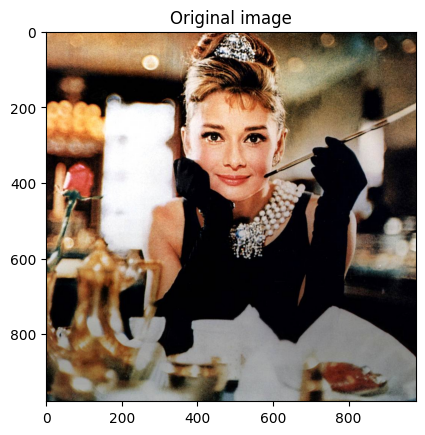

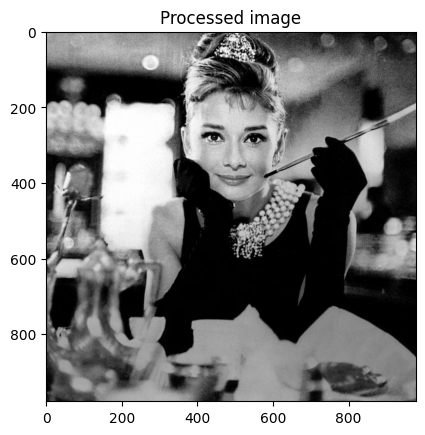

In [59]:
main()